# Developing a microscopy pipeline

In [1]:
import os
import glob
import pickle
import datetime
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special

# Import the project utils
import sys
import image_analysis_utils as im_utils

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

# Image analysis libraries
import skimage.io
import skimage.filters
import skimage.segmentation
import scipy.ndimage

# Set plotting style
im_utils.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Image analysis to obtain gene expression distributions.

As the project requires us to measure the gene expression distribution of the cells we will be using microscopy to get that distribution out of images. For this we will take advantage of the mCherry volume marker the cells have. We will be using Laplacian of the Gaussian segmentation to find the cells.

### Credit : Griffin Chure
This pipeline was entirely developed by Griffin Chure.

# Correcting uneven illumination

The first step will be to ensure that the fluorescence illumination of the images is uniform in both the segmentaion and the interrogation channel. This will be done by making a look-up table of the illumination profile of both channels. The correction will be performed by manipulating each image as

$$
I_{flat} = \frac{I - I_{noise}}{I_{ill} - I_{noise}}\cdot\frac{1}{n_{pix}}\sum\limits_{i,j}^{n_{pix}}(I_{ill,i,j} - I_{noise, i,j}),
$$

where $I$ is the image of interest, $I_{dark}$ is the average noise of the camera, i.e. images that were taken with the same exposure as the image of interest but with the light not going to the camara. $I_{ill}$ is the averaged illumination profile of the fluorescence channel, i.e. images taken with short exposure on a fluorescent slide. $n_{pix}$ is the number of pixels in the image, $I_{i,j}$ is the pixel value at coordinate $i,j$, $I_{flat}$ is our desired flat-field image. We'll start by defining some functions needed for this correction. 

In [30]:
def average_stack(im, median_filt=True):
    """
    Computes an average image from a provided array of images.

    Parameters
    ----------
    im : list or arrays of 2d-arrays
        Stack of images to be filtered.
    median_filt : bool
        If True, each image will be median filtered before averaging.
        Median filtering is performed using a 3x3 square structural element.

    Returns
    -------
    im_avg : 2d-array
        averaged image with a type of int.
    """

    # Determine if the images should be median filtered.
    if median_filt is True:
        selem = skimage.morphology.square(3)
        im_filt = [scipy.ndimage.median_filter(i, footprint=selem) for i in im]
    else:
        im = im_filt

    # Generate and empty image to store the averaged image.
    im_avg = np.zeros_like(im[0]).astype(int)
    for i in im:
        im_avg += i
    im_avg = im_avg / len(im)
    return im_avg

It will be pedagogically useful to look at the averaged illumination profile for bot the YFP and RFP channels as well as the camera noise. Let's generate and display those

In [31]:
# Define the data directory.
data_dir = '../../../data/microscopy/20161118/'

# Glob the profile and noise images.
yfp_glob = glob.glob(data_dir + '*yfp_profile*/*.tif')
rfp_glob = glob.glob(data_dir + '*mCherry_profile*/*.tif')
noise_glob = glob.glob(data_dir + '*noise*/*.tif')

# Load the images as collections
yfp_profile = skimage.io.ImageCollection(yfp_glob)
rfp_profile = skimage.io.ImageCollection(rfp_glob)
noise_profile = skimage.io.ImageCollection(noise_glob)

# Need to split the noise profile image into the two channels
noise_rfp = [noise_profile[i][0] for i, _ in enumerate(noise_profile)]
noise_yfp = [noise_profile[i][1] for i, _ in enumerate(noise_profile)]

/Users/razo/anaconda/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:1106: UserWarning: ome-xml: not an ome-tiff master file
  warnings.warn("ome-xml: not an ome-tiff master file")


In [32]:
# Generate averages and plot them. 
rfp_avg = average_stack(yfp_profile)
yfp_avg = average_stack(yfp_profile)

rfp_noise = average_stack(noise_rfp)
yfp_noise = average_stack(noise_yfp)

/Users/razo/anaconda/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:1106: UserWarning: ome-xml: not an ome-tiff master file
  warnings.warn("ome-xml: not an ome-tiff master file")


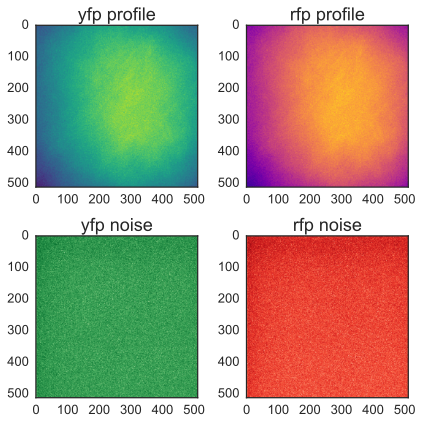

In [34]:
with sns.axes_style('white'):
    fig, ax =  plt.subplots(2, 2, figsize=(6,6))
    ax = ax.ravel()
    ax[0].imshow(yfp_avg, cmap=plt.cm.viridis)
    ax[0].set_title('yfp profile')
    ax[1].imshow(rfp_avg, cmap=plt.cm.plasma)
    ax[1].set_title('rfp profile')
    ax[2].imshow(yfp_noise, cmap=plt.cm.Greens_r)
    ax[2].set_title('yfp noise')
    ax[3].imshow(rfp_noise, cmap=plt.cm.Reds_r)
    ax[3].set_title('rfp noise')
plt.tight_layout()
plt.savefig('./20161118_O2_RBS1027_IPTG_titration_microscopy/outdir/' + \
            'background_correction.png')

# Analyze the images


Define the log segmentation functions.

These series of functions will be included in the `image_analysis_utils.py` file for further use.

In [4]:
def ome_split(im):
    """Splits an ome.tiff image into individual channels"""
    if len(np.shape(im)) != 3:
        raise RuntimeError('provided image must be a single image')
    ims = []
    for i in range(np.shape(im)[-1]):
        ims.append(im[:, :, i])
    return ims

def generate_flatfield(im, im_dark, im_field, median_filt=True):
    """
    Corrects illumination of a given image using a dark image and an image of
    the flat illumination.

    Parameters
    ----------
    im : 2d-array
        Image to be flattened.
    im_dark : 2d-array
        Average image of camera shot noise (no illumination).
    im_field: 2d-array
        Average image of fluorescence illumination.
    median_filt : bool
        If True, the image to be corrected will be median filtered with a
        3x3 square structural element.

    Returns
    -------
    im_flat : 2d-array
        Image corrected for uneven fluorescence illumination. This is performed
        as

        im_flat = ((im - im_dark) / (im_field - im_dark)) *
                   mean(im_field - im_dark)

    Raises
    ------
    RuntimeError
        Thrown if bright image and dark image are approximately equal. This
        will result in a division by zero.
    """

    # Ensure that the same image is not being provided as the bright and dark.
    if np.isclose(im_field, im_dark).all():
        raise RuntimeError('im_bright and im_dark are approximately equal.')

    # Compute the mean difference between the bright and dark image.
    mean_diff = np.mean(im_field - im_dark)

    if median_filt is True:
        selem = skimage.morphology.square(3)
        im_filt = scipy.ndimage.median_filter(im, footprint=selem)
    else:
        im_filt = im

    # Compute and return the flattened image.
    im_flat = ((im_filt - im_dark) / (im_field - im_dark)) * mean_diff
    return im_flat

def find_zero_crossings(im, selem, thresh):
    """
    This  function computes the gradients in pixel values of an image after
    applying a sobel filter to a given image. This  function is later used in
    the Laplacian of Gaussian cell segmenter (log_segmentation) function. The
    arguments are as follows.

    Parameters
    ----------
    im : 2d-array
        Image to be filtered.
    selem : 2d-array, bool
        Structural element used to compute gradients.
    thresh :  float
        Threshold to define gradients.

    Returns
    -------
    zero_cross : 2d-array
        Image with identified zero-crossings.

    Notes
    -----
    This function as well as `log_segmentation` were written by Justin Bois.
    http://bebi103.caltech.edu/
    """

    # apply a maximum and minimum filter to the image.
    im_max = scipy.ndimage.filters.maximum_filter(im, footprint=selem)
    im_min = scipy.ndimage.filters.minimum_filter(im, footprint=selem)

    # Compute the gradients using a sobel filter.
    im_filt = skimage.filters.sobel(im)

    # Find the zero crossings.
    zero_cross = (((im >= 0) & (im_min < 0)) | ((im <= 0) & (im_max > 0)))\
        & (im_filt >= thresh)

    return zero_cross

def log_segmentation(im, selem='default', thresh=0.0001, radius=2.0,
                     median_filt=True, clear_border=True, label=False):
    """
    This function computes the Laplacian of a gaussian filtered image and
    detects object edges as regions which cross zero in the derivative.

    Parameters
    ----------
    im :  2d-array
        Image to be processed. Must be a single channel image.
    selem : 2d-array, bool
        Structural element for identifying zero crossings. Default value is
        a 2x2 pixel square.
    radius : float
        Radius for gaussian filter prior to computation of derivatives.
    median_filt : bool
        If True, the input image will be median filtered with a 3x3 structural
        element prior to segmentation.
    selem : 2d-array, bool
        Structural element to be applied for laplacian calculation.
    thresh : float
        Threshold past which
    clear_border : bool
        If True, segmented objects touching the border will be removed.
        Default is True.
    label : bool
        If True, segmented objecs will be labeled. Default is False.

    Returns
    -------
    im_final : 2d-array
        Final segmentation mask. If label==True, the output will be a integer
        labeled image. If label==False, the output will be a bool.

    Notes
    -----
    We thank Justin Bois in his help writing this function.
    https://bebi103.caltech.edu
    """

    # Test that the provided image is only 2-d.
    if len(np.shape(im)) > 2:
        raise ValueError('image must be a single channel!')

    # Determine if the image should be median filtered.
    if median_filt is True:
        selem = skimage.morphology.square(3)
        im_filt = scipy.ndimage.median_filter(im, footprint=selem)
    else:
        im_filt = im
    # Ensure that the provided image is a float.
    if np.max(im) > 1.0:
        im_float = skimage.img_as_float(im_filt)
    else:
        im_float = im_filt

    # Compute the LoG filter of the image.
    im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float, radius)

    # Define the structural element.
    if selem == 'default':
        selem = skimage.morphology.square(3)

    # Using find_zero_crossings, identify the edges of objects.
    edges = find_zero_crossings(im_LoG, selem, thresh)

    # Skeletonize the edges to a line with a single pixel width.
    skel_im = skimage.morphology.skeletonize(edges)

    # Fill the holes to generate binary image.
    im_fill = scipy.ndimage.morphology.binary_fill_holes(skel_im)

    # Remove small objects and objects touching border.
    im_final = skimage.morphology.remove_small_objects(im_fill)
    if clear_border is True:
        im_final = skimage.segmentation.clear_border(im_final, buffer_size=5)

    # Determine if the objects should be labeled.
    if label is True:
        im_final = skimage.measure.label(im_final)

    # Return the labeled image.
    return im_final

def props_to_df(mask, physical_distance=1, intensity_image=None):
    """
    Converts the output of skimage.measure.regionprops to a nicely
    formatted pandas DataFrame.

    Parameters
    ----------
    mask : 2d-array, int
        Segmentation mask containing objects to be measured.
    physical_distance : int or float
        Interpixel distance of the image. This will be used to
        convert the area measurements to meaningful units.
    intensity_image : 2d-array
        Intensity image for intensity based measurements. If none is
        provided, only region based measurements will be returned.

    Returns
    -------
    df : pandas DataFrame
        Tidy DataFrame containing all measurements.

    """

    # Ensure that there is at least one object in the image.
    if np.max(mask) == 0:
        raise ValueError('no objects found in image.')

    # Define the values that are to be extracted.
    REGIONPROPS = ('area', 'eccentricity', 'solidity',
                   'mean_intensity')

    if intensity_image is None:
        measurements = REGIONPROPS[:-3]
    else:
        measurements = REGIONPROPS

    # Iterate through and extract the props.
    props = skimage.measure.regionprops(mask,
                                        intensity_image=intensity_image)
    for i, p in enumerate(props):
        extracted = []
        for val in measurements:
            extracted.append(p[val])

        if i == 0:
            df = pd.DataFrame(extracted).T
        else:
            df2 = pd.DataFrame(extracted).T
            df = df.append(df2)
    df.columns = measurements
    df['area'] = df['area'] * physical_distance**2
    return df

def example_segmentation(mask, im, bar_length, bounds=True):
    """
    Generates and example segmentation with segmentation mask shown in red over
    the original phase image.

    Parameters
    ----------
    mask : 2d-array, bool
        Boolean mask of segmented objects.
    im : 2d-array, float
        Original image on which the segmentation mask will be overlaid.
    bar_length : int
        Length of scale bar in units of pixels.
    bounds : bool
        If True, only teh bounds of the segmentation mask will be shown around
        each object.

    Returns
    -------
    merge : 3d-array
        Merged segmentation mask.
    """

    # Ensure that the original image is a float and the mask is a bool.
    if np.max(im) > 1:
        im = (im - im.min()) / (im.max() - im.min())
    if np.max(mask) > 0:
        mask = mask > 0

    # Determine if the bounds should be hsown.
    if bounds is True:
        mask = skimage.segmentation.find_boundaries(mask)
    im_copy = np.copy(im)
    im_copy[mask] = 1.0

    return np.dstack((im_copy, im, im))

In order to analyze the images let's define the *metadata* for this particular experiment.

In [2]:
DATE = 20161118
USERNAME = 'mrazomej'
OPERATOR = 'O2'
BINDING_ENERGY = -13.9
REPRESSORS = (0, 0, 130)
IPDIST = 0.160  # in units of µm per pixel
STRAINS = ['auto', 'delta', 'RBS1027']
IPTG_RANGE = (0, 0.1, 5, 10, 25, 50, 75, 100, 250, 500, 1000, 5000)

In [20]:
# Iterate through each strain and concentration to make the dataframes.
dfs = []
ex_iptg = np.random.choice(IPTG_RANGE)
for i, st in enumerate(STRAINS):
    print(st)
    for j, iptg in enumerate(IPTG_RANGE):
        # Load the images
        if (iptg==0) & (st != 'RBS1027'):
            images = glob.glob(data_dir + '*' + st + '_*/*.tif')
            
        else:
            images = glob.glob(data_dir + '*' + st + '*_' + str(iptg) +
                           'uMIPTG*/*.ome.tif')
            
        if len(images) is not 0:
            ims = skimage.io.ImageCollection(images)
    
            for _, x in enumerate(ims):
                _, m, y = ome_split(x)
                y_flat = generate_flatfield(y, yfp_noise, yfp_avg)
    
                # Segment the mCherry channel.
                m_seg = log_segmentation(m, label=True)
                if iptg == ex_iptg:
                    ex_seg = m_seg
                    ex_phase = _
    
                # Extract the measurements.
                im_df = props_to_df(m_seg, physical_distance=IPDIST,
                                        intensity_image=y_flat)
    
                # Add strain and  IPTG concentration information.
                im_df.insert(0, 'IPTG_uM', iptg)
                im_df.insert(0, 'repressors', REPRESSORS[i])
                im_df.insert(0, 'rbs', st)
                im_df.insert(0, 'binding_energy', BINDING_ENERGY)
                im_df.insert(0, 'operator', OPERATOR)
                im_df.insert(0, 'username', USERNAME)
                im_df.insert(0, 'date', DATE)
    
                # Append the dataframe to the global list.
                dfs.append(im_df)

# Concatenate the dataframe
df_im = pd.concat(dfs, axis=0)
df_im.to_csv('./20161118_O2_RBS1027_IPTG_titration_microscopy/outdir/' +\
               str(DATE) + '_' + OPERATOR + '_' +\
               STRAINS[-1] + '_raw_segmentation.csv', index=False)

auto


/Users/razo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:159: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


delta
RBS1027


In [3]:
df_im = pd.read_csv('./20161118_O2_RBS1027_IPTG_titration_microscopy/outdir/' +\
               str(DATE) + '_' + OPERATOR + '_' +\
               STRAINS[-1] + '_raw_segmentation.csv')
df_im.head()

date  username operator  binding_energy   rbs  repressors  IPTG_uM  \
0  20161118  mrazomej       O2           -13.9  auto           0      0.0   
1  20161118  mrazomej       O2           -13.9  auto           0      0.0   
2  20161118  mrazomej       O2           -13.9  auto           0      0.0   
3  20161118  mrazomej       O2           -13.9  auto           0      0.0   
4  20161118  mrazomej       O2           -13.9  auto           0      0.0   

     area  eccentricity  solidity  mean_intensity  
0  4.1984      0.962913  0.896175       91.284559  
1  3.9424      0.947307  0.922156       79.274082  
2  8.6528      0.895430  0.600355       85.723149  
3  2.7904      0.887267  0.947826       92.690586  
4  3.7888      0.946231  0.896970       90.192167

## Analyzing the resulting segmentation.

Let's look at the results. First let's plot the ECDF of the area, and excentricity.

In [37]:
def ecdf(data):
    """
    Computes the empirical cumulative distribution function (ECDF)
    of a given set of 1D data.

    Parameters
    ----------
    data : 1d-array
        Data from which the ECDF will be computed.

    Returns
    -------
    x, y : 1d-arrays
        The sorted data (x) and the ECDF (y) of the data.
    """

    return np.sort(data), np.arange(len(data))/len(data)

In [38]:
df_group = df_im.groupby('rbs')

fig, ax = plt.subplots(1, 2, figsize=(8,4))
for group, data in df_group:
    area_ecdf = ecdf(df_im.area)
    ecc_ecdf = ecdf(df_im.eccentricity)
    ax[0].plot(area_ecdf[0], area_ecdf[1], marker='.', linewidth=0,
             label=group, alpha=0.5)
    ax[1].plot(ecc_ecdf[0], ecc_ecdf[1], marker='.', linewidth=0,
             label=group, alpha=0.5)
    
# Format plots
ax[0].legend(loc='lower right', title='strain')
ax[0].set_xlabel(r'area ($\mu$m$^2$)')
ax[0].set_ylabel('ECDF')
ax[0].margins(0.02)

ax[1].set_xlabel(r'eccentricity')
ax[1].set_ylabel('ECDF')
ax[1].margins(0.02)

plt.tight_layout()
plt.savefig('./20161118_O2_RBS1027_IPTG_titration_microscopy/outdir/ecdf.png',
           bbox_inches='tight')

Let's apply filteres with respect to area and eccentricity. We will choose cells not smaller than 0.5 and not larger than 6 microns square. For the aspect ratio we will choose 0.8 for our lower bound.

In [5]:
# Apply the area and eccentricity bounds.
df_filt = df_im[(df_im.area > 0.5) & (df_im.area < 6.0) &
                     (df_im.eccentricity > 0.8)]
# Save file in the same directory as the summary plots
df_filt.to_csv('./20161118_O2_RBS1027_IPTG_titration_microscopy/outdir/' +\
               str(DATE) + '_' + OPERATOR + '_' +\
               STRAINS[-1] + '_IPTG_titration_microscopy.csv', index=False)

# Export file to data directory including the comments
filenames = ['./20161118_O2_RBS1027_IPTG_titration_microscopy/README.txt', 
             './20161118_O2_RBS1027_IPTG_titration_microscopy/outdir/' +
             str(DATE) + '_' + OPERATOR + '_' +\
             STRAINS[-1] + '_IPTG_titration_microscopy.csv']

with open('../../../data/' + str(DATE) + '_' + OPERATOR + '_' +\
               STRAINS[-1] + '_IPTG_titration_microscopy.csv', 'w') as output:
    for fname in filenames:
        with open(fname) as infile:
            output.write(infile.read())

# Computing mean fold-change

As a diagnostic tool for the data let's compute the fold-change and compare it to the theoretical expectation. 

In [6]:
df_filt.head()

date  username operator  binding_energy   rbs  repressors  IPTG_uM  \
0  20161118  mrazomej       O2           -13.9  auto           0      0.0   
1  20161118  mrazomej       O2           -13.9  auto           0      0.0   
3  20161118  mrazomej       O2           -13.9  auto           0      0.0   
4  20161118  mrazomej       O2           -13.9  auto           0      0.0   
5  20161118  mrazomej       O2           -13.9  auto           0      0.0   

     area  eccentricity  solidity  mean_intensity  
0  4.1984      0.962913  0.896175       91.284559  
1  3.9424      0.947307  0.922156       79.274082  
3  2.7904      0.887267  0.947826       92.690586  
4  3.7888      0.946231  0.896970       90.192167  
5  4.0704      0.954322  0.898305       72.529495

In [7]:
# Compute mean intensity for auto and delta strains
mean_auto = df_filt[df_filt.rbs == 'auto'].mean_intensity.mean()
mean_delta = df_filt[df_filt.rbs == 'delta'].mean_intensity.mean()

# Group analysis strain by RBS
df_group = df_filt[df_filt.rbs == STRAINS[-1]].groupby('IPTG_uM')

# Initialize dataframe to save fold change
df_fc = pd.DataFrame(columns=['IPTG', 'fold_change'])
for group, data in df_group:
    fold_change = (data.mean_intensity.mean() - mean_auto) /\
                  (mean_delta - mean_auto)
    df_tmp =  pd.DataFrame([group, fold_change], index=['IPTG', 'fold_change']).T
    df_fc = pd.concat([df_fc, df_tmp], axis=0)

df_fc.head()

IPTG  fold_change
0   0.0     0.012458
0   0.1     0.012707
0   5.0     0.031084
0  10.0     0.056440
0  25.0     0.170077

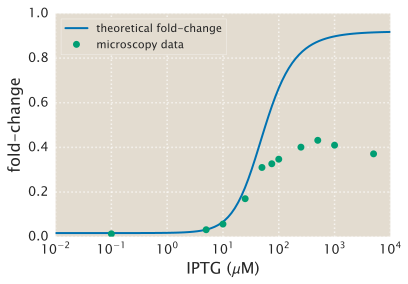

In [9]:
# Compute the theoretical fold change
iptg = np.logspace(-2, 4, 100)
fc = im_utils.fold_change(iptg=iptg, ka=141.52, ki=0.56061, epsilon=4.5, 
                          R=REPRESSORS[-1],  epsilon_r=BINDING_ENERGY)
plt.figure()
plt.plot(iptg, fc, label='theoretical fold-change')
plt.plot(df_fc.IPTG, df_fc.fold_change, marker='o', linewidth=0,
         label='microscopy data')
plt.xscale('log')
plt.legend(loc=0)
plt.xlabel(r'IPTG ($\mu$M)')
plt.ylabel(r'fold-change')
plt.savefig('./20161118_O2_RBS1027_IPTG_titration_microscopy/outdir/' + \
            'fold_change.png')

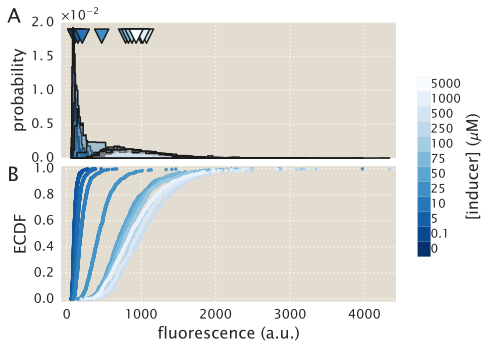

In [59]:
concentrations = df_filt.IPTG_uM.unique()
colors = sns.color_palette("Blues_r", len(concentrations))

fig, ax = plt.subplots(2, 1, figsize=(6,5), sharex=True)

# Set the nice scientific notation for the y axis of the histograms
ax[0].yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(\
                             useMathText=True, 
                             useOffset=False))
ax[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter(\
                             useMathText=True, 
                             useOffset=False))

# Group data frame by concentration
df_group = df_filt[df_filt.rbs == 'RBS1027'].groupby('IPTG_uM')

# initialize counter for colors
i = 0
mean_fl = []
for c, data in df_group:
    mean_int = data.mean_intensity
    mean_fl.append(mean_int.mean())
    # Histogram plot
    n, bins, patches = ax[0].hist(mean_int, 30,
                                normed=1, histtype='stepfilled', alpha=0.4,
                                label=str(c)+ r' $\mu$M', facecolor=colors[i],
                               linewidth=1)
    n, bins, patches = ax[0].hist(mean_int, 30,
                                normed=1, histtype='stepfilled', 
                                label='', edgecolor='k',
                               linewidth=1.5, facecolor='none')
    # ECDF Plot
    x, y = ecdf(mean_int)
    ax[1].plot(x, y, '.', label=str(c)+ r' $\mu$M', color=colors[i])
    
    # Increase counter
    i += 1

# Declare color map for legend
cmap = plt.cm.get_cmap('Blues_r', len(concentrations))
bounds = np.linspace(0, len(concentrations), len(concentrations) + 1)

# # Plot a little triangle indicating the mean of each distribution
mean_plot = ax[0].scatter(mean_fl, [0.018] * len(mean_fl), marker='v', s=200,
            c=np.arange(len(mean_fl)), cmap=cmap,
            edgecolor='k',
            linewidth=1.5)
# Generate a colorbar with the concentrations
cbar_ax = fig.add_axes([0.95, 0.25, 0.03, 0.5])
cbar = fig.colorbar(mean_plot, cax=cbar_ax)
cbar.ax.get_yaxis().set_ticks([])
for j, c in enumerate(concentrations):
    if c == 0.1:
        c = str(c)
    else:
        c = str(int(c))
    cbar.ax.text(1, j / len(concentrations) + 1 / (2 * len(concentrations)),
                 c, ha='left', va='center',
                 transform = cbar_ax.transAxes, fontsize=12)
cbar.ax.get_yaxis().labelpad = 35
cbar.set_label(r'[inducer] ($\mu$M)')

ax[0].set_ylim(bottom=0, top=0.02)
ax[0].set_ylabel('probability')
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
 
ax[1].margins(0.02)
ax[1].set_xlabel('fluorescence (a.u.)')
ax[1].set_ylabel('ECDF')

plt.figtext(0.0, .9, 'A', fontsize=20)
plt.figtext(0.0, .46, 'B', fontsize=20)

plt.subplots_adjust(hspace=0.06)
plt.savefig('./20161118_O2_RBS1027_IPTG_titration_microscopy/outdir/' + 
           'fluor_ecdf.png')